# Spatial Interpolation

In [1]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 9)
import warnings
warnings.filterwarnings('ignore')


In [2]:
import rasterio

In [3]:
from rasterio.mask import mask
import geopandas as gpd
import fiona
import pandas as pd

In [4]:
precip = gpd.read_file("precip_sd.geojson")


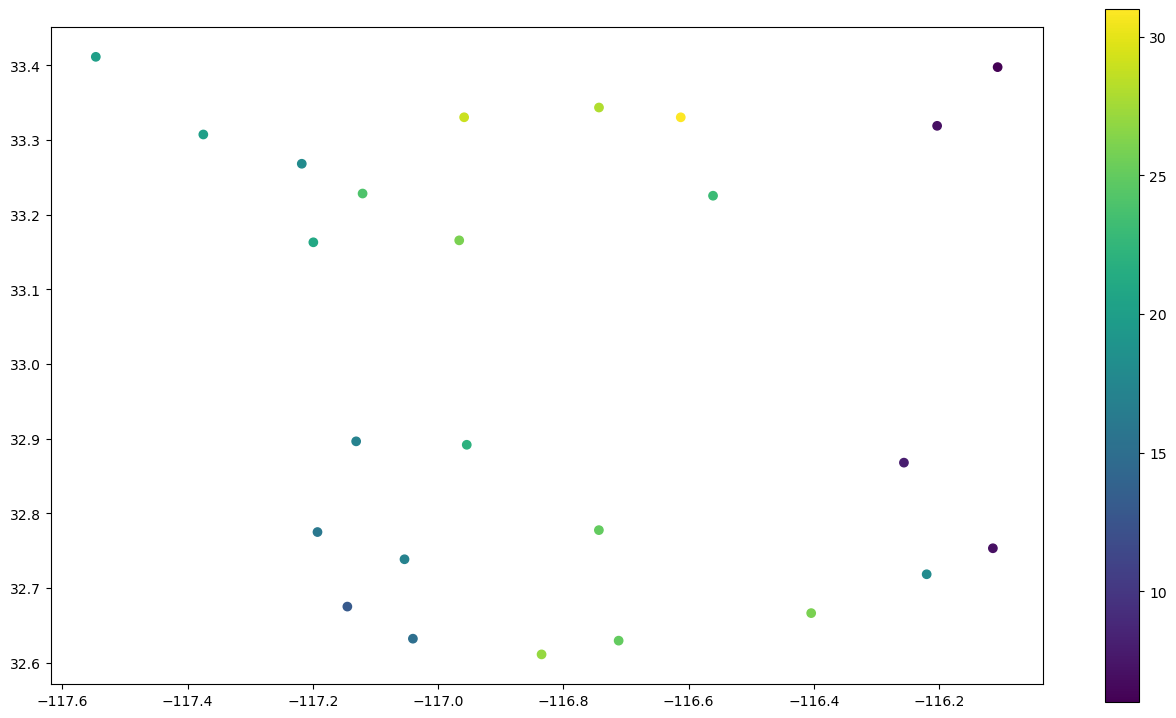

In [5]:
precip.plot(column='inches', legend=True);

In [6]:
county = gpd.read_file("sdcounty.geojson")

In [7]:
m = county.explore()
precip.explore(column='inches', m=m)


## Interpolation Methods

### Voronoi Partition Interpolation

In [8]:
from libpysal.cg import voronoi_frames
points = [(10.2, 5.1), (4.7, 2.2), (5.3, 5.7), (2.7, 5.3)]
regions_df, points_df = voronoi_frames(points)
regions_df.shape
(4, 1)

(4, 1)

<Axes: >

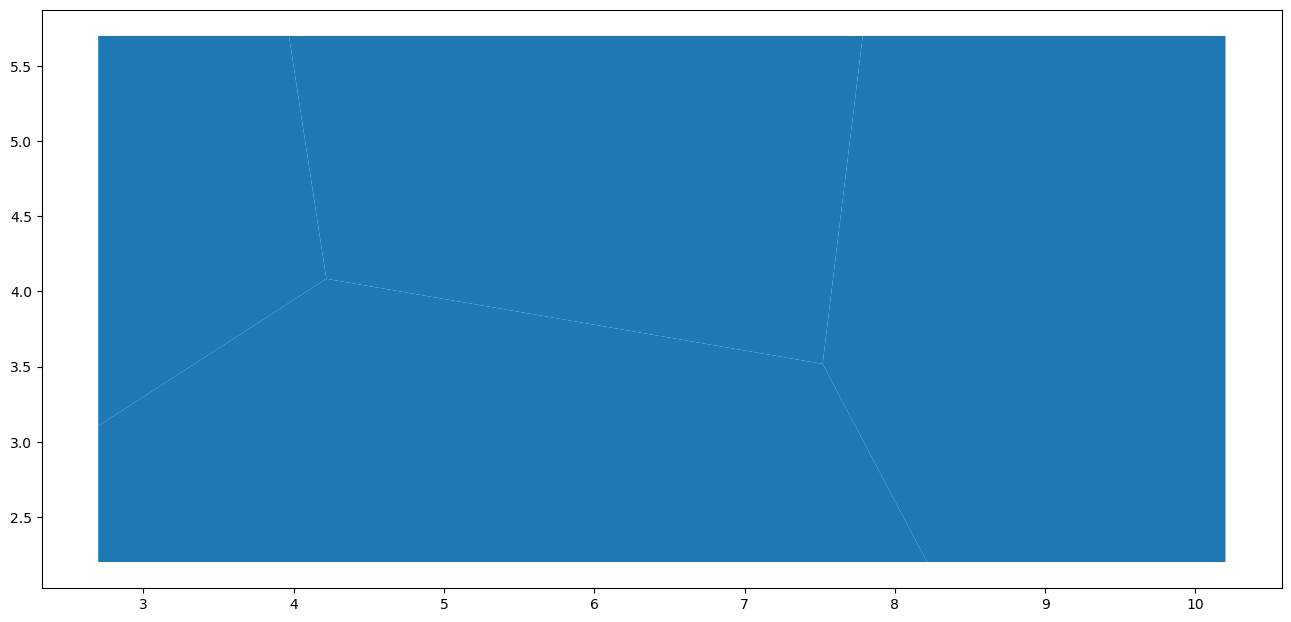

In [9]:
regions_df.plot()

In [10]:
#libpysal.cg.voronoi_frames(points, radius=None, clip='extent')
points = precip.get_coordinates().values

In [11]:
points

array([[-116.11392643,   32.75307635],
       [-117.12067477,   33.22819891],
       [-117.54677523,   33.41129941],
       [-116.9663248 ,   33.16548448],
       [-116.83479485,   32.61090996],
       [-116.95845807,   33.33033923],
       [-117.04029442,   32.63195628],
       [-117.37505941,   33.30728301],
       [-116.40414067,   32.66621206],
       [-117.19270233,   32.77478741],
       [-116.61247649,   33.33028661],
       [-116.7430757 ,   33.34341133],
       [-116.21969099,   32.71825351],
       [-116.20299833,   33.31887981],
       [-117.05371254,   32.73833341],
       [-116.25599174,   32.86774382],
       [-117.1993245 ,   33.16287784],
       [-117.1449864 ,   32.67494802],
       [-116.95429142,   32.89167509],
       [-117.13095076,   32.89629192],
       [-116.74322953,   32.77737283],
       [-116.71168297,   32.62932523],
       [-116.10634354,   33.3975104 ],
       [-117.21780769,   33.2680768 ],
       [-116.56091847,   33.22526384]])

<Axes: >

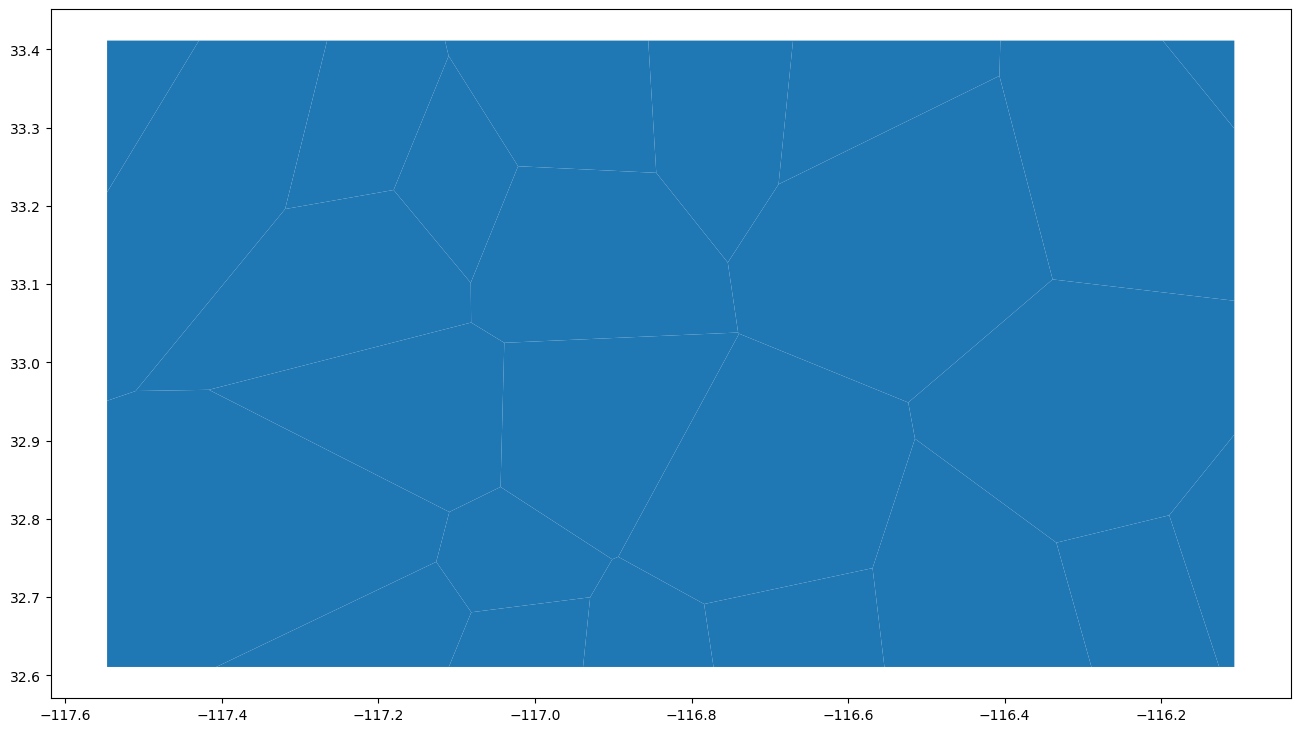

In [12]:
v_gdf, v_p = voronoi_frames(points)

v_gdf.plot()

<Axes: >

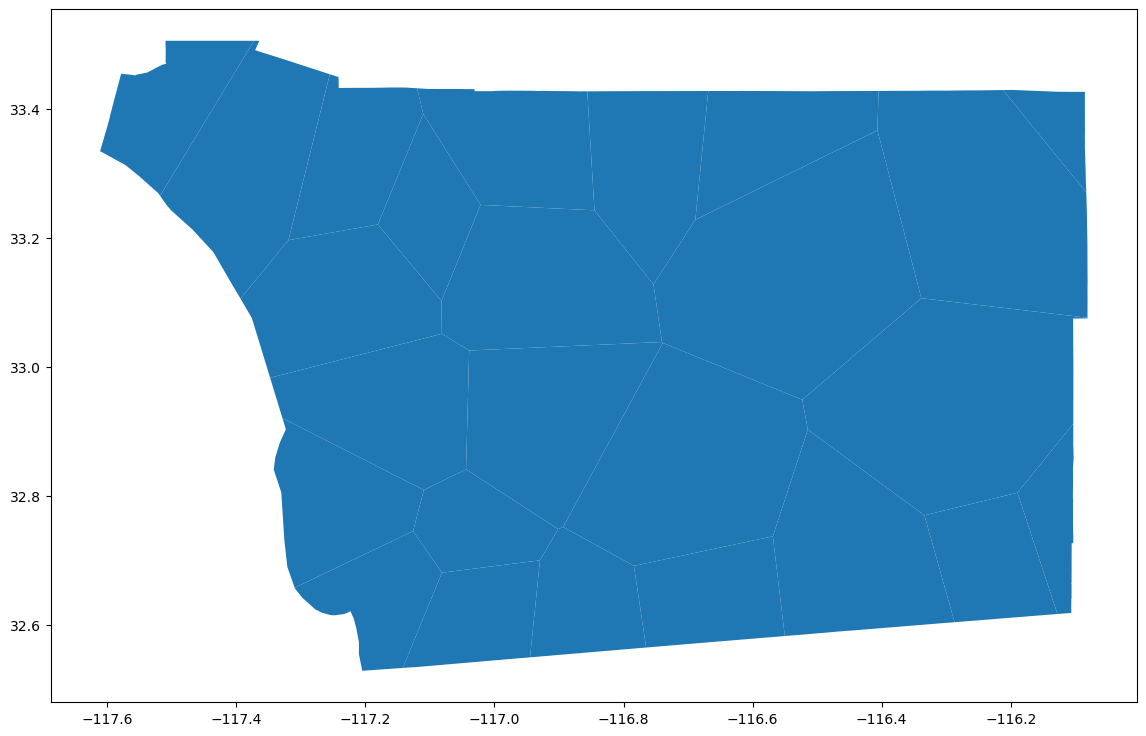

In [13]:
v_gdf, v_p = voronoi_frames(points, clip=county.geometry[0])

v_gdf.plot()

In [14]:
v_gdf['inches'] = precip.inches

<Axes: >

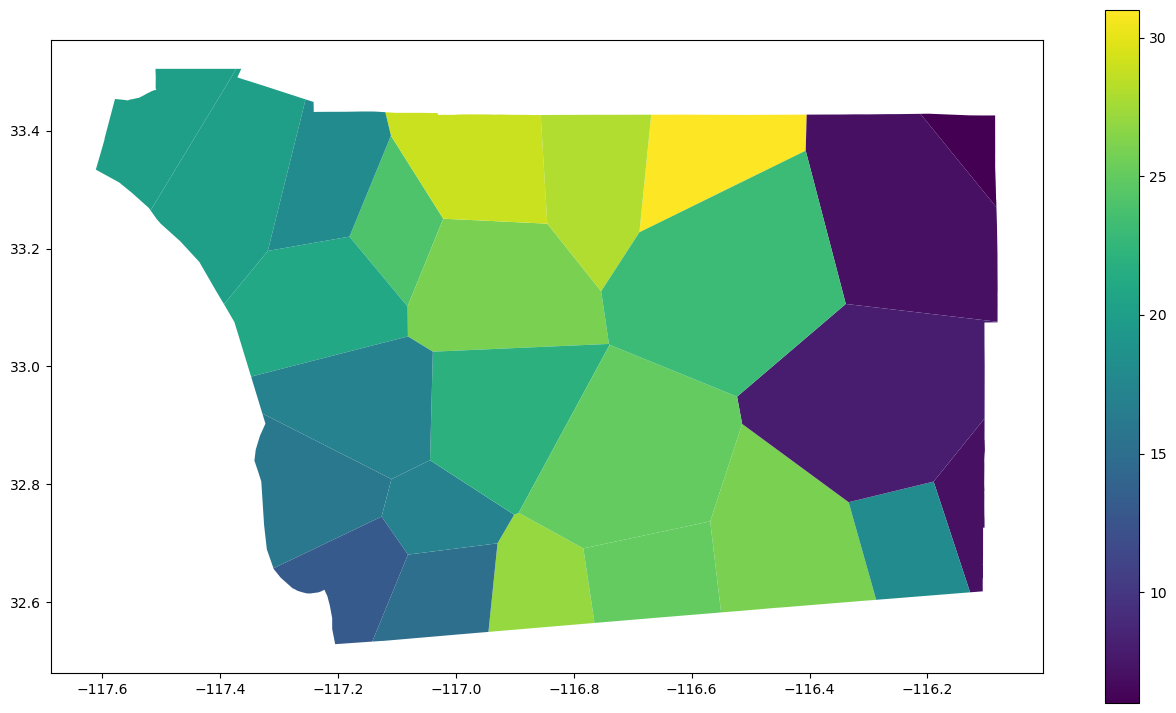

In [15]:
v_gdf.plot(column='inches', legend=True)

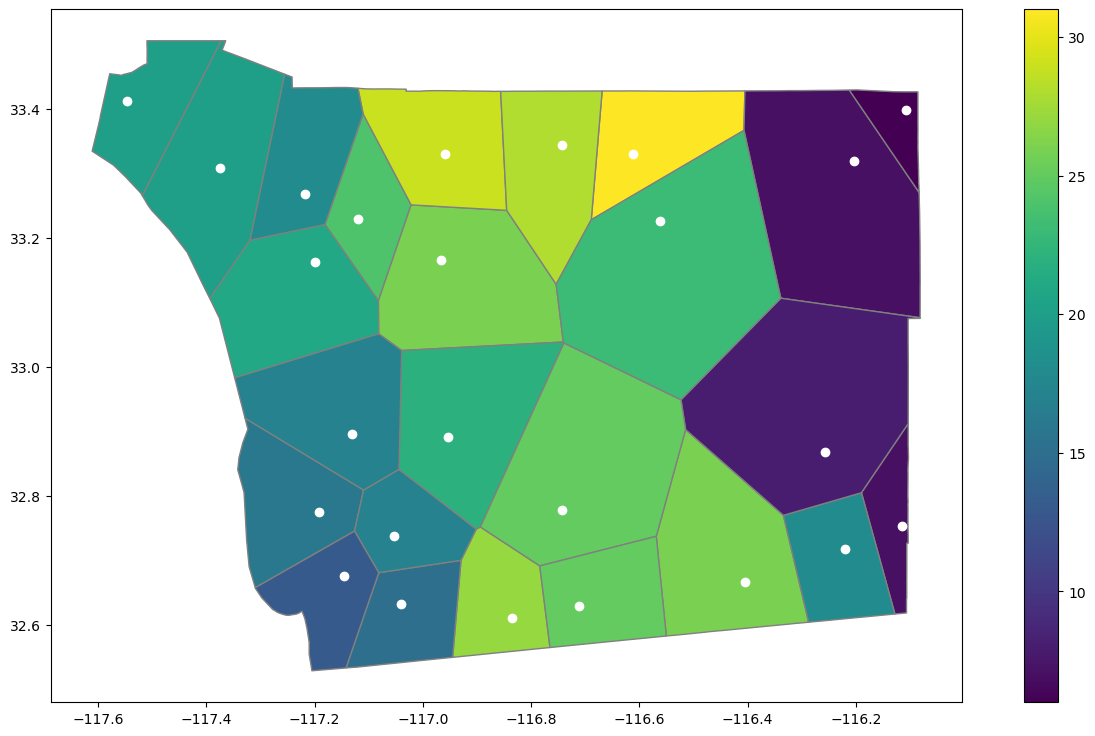

In [16]:
base = v_gdf.plot(column='inches', legend=True,
                 edgecolor='gray')
precip.plot(ax=base, color='w');

### Interpolate to Grids

- hex3 the county
- nearest neighbor interpolators
- 

In [17]:
import tobler

In [18]:
county_utm = county.to_crs(county.estimate_utm_crs())
precip_utm = precip.to_crs(precip.estimate_utm_crs())

In [19]:
from tobler.util import h3fy


In [20]:
county_h3 = h3fy(county_utm)

<Axes: >

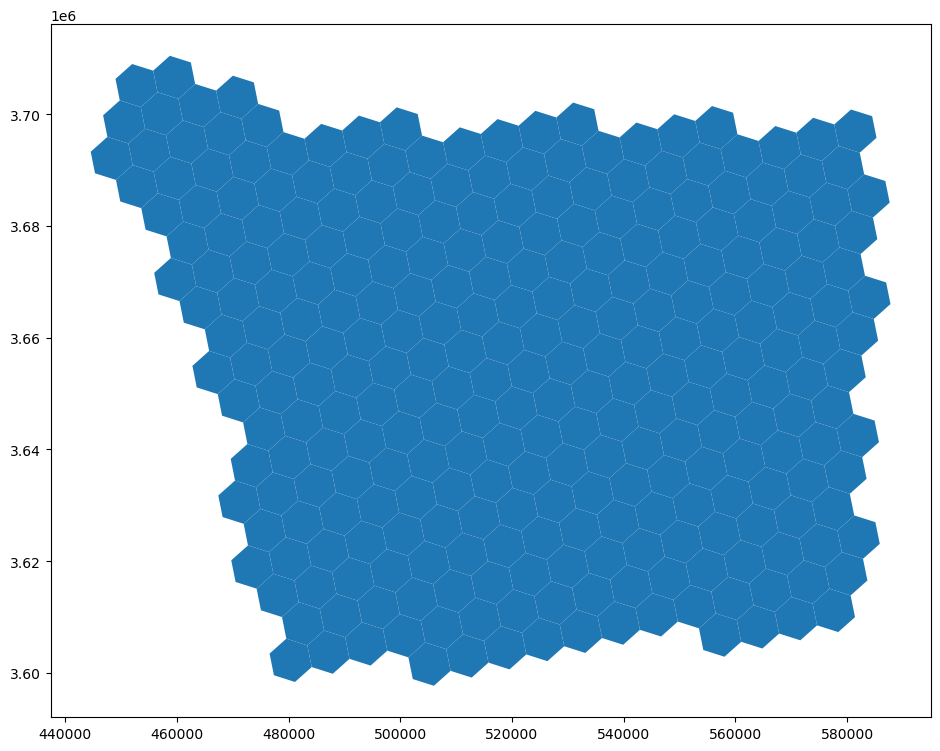

In [21]:
county_h3.plot()

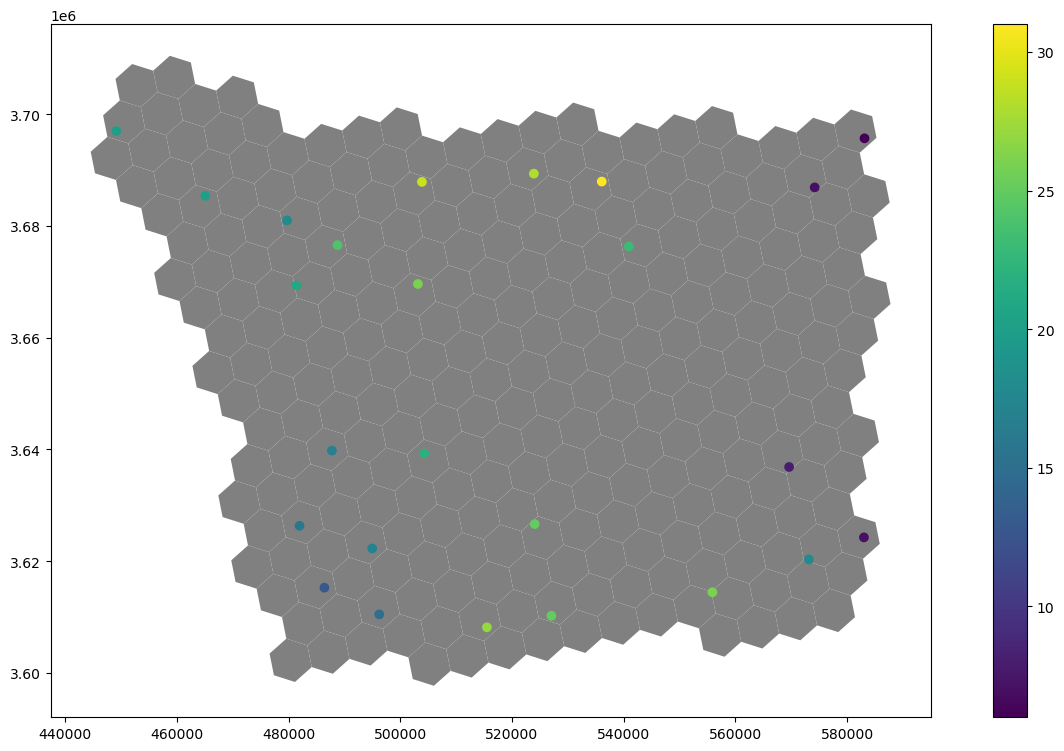

In [22]:
m = county_h3.plot(color='grey')
precip_utm.plot(column='inches', ax=m, legend=True);

### Nearest neighbor

In [23]:
hcents = county_h3.centroid


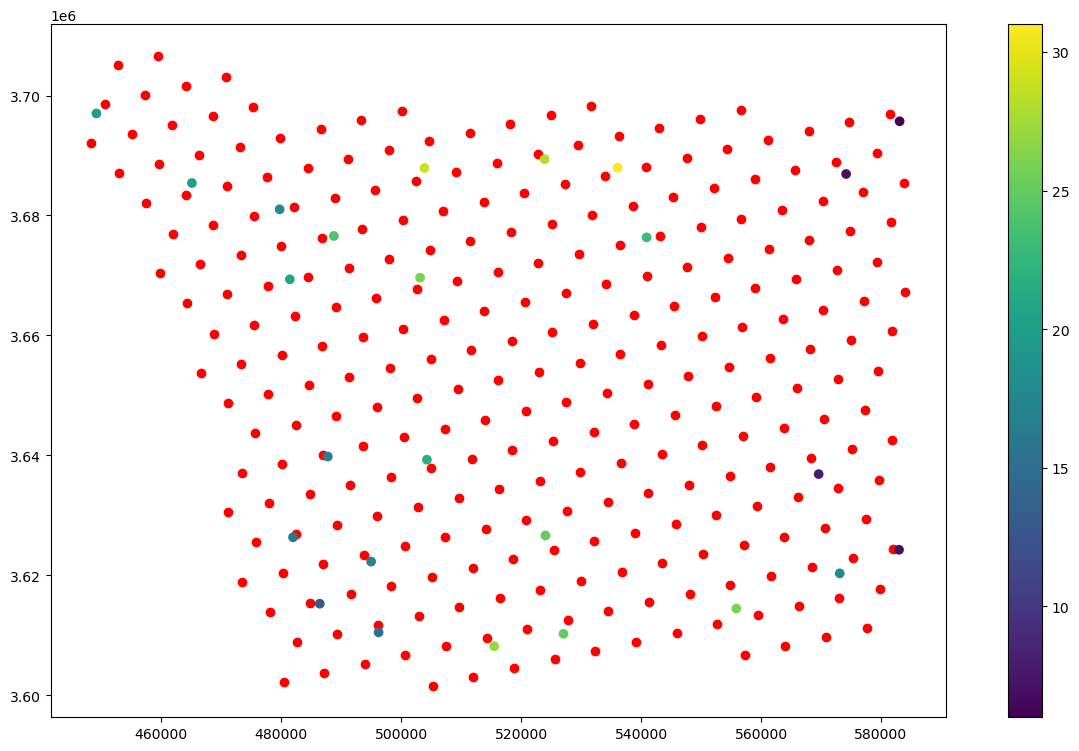

In [24]:
m = hcents.plot(color='r')
precip_utm.plot(column='inches', ax=m, legend=True);

In [25]:
gpd.sjoin_nearest(county_h3, precip_utm, distance_col="distances",
    lsuffix="left", rsuffix="right", exclusive=True)

geometry  \
hex_id                                                               
8629a6a0fffffff  POLYGON ((537048.394 3689328.650, 540042.930 3...   
8629a6a07ffffff  POLYGON ((541604.239 3684268.446, 544599.450 3...   
8629a6a57ffffff  POLYGON ((532494.502 3694386.661, 535488.364 3...   
8629a6b57ffffff  POLYGON ((532618.678 3676253.158, 535613.850 3...   
8629a6a17ffffff  POLYGON ((548376.217 3685745.697, 551371.779 3...   
...                                                            ...   
8629a42d7ffffff  POLYGON ((453619.190 3683208.511, 456608.225 3...   
8629a092fffffff  POLYGON ((455838.093 3689733.627, 458826.856 3...   
8629a090fffffff  POLYGON ((458056.590 3696257.420, 461045.077 3...   
8629a6937ffffff  POLYGON ((578262.158 3625515.280, 581264.072 3...   
86485966fffffff  POLYGON ((582836.817 3620429.699, 585839.404 3...   

                 index_right  inches    distances  
hex_id                                             
8629a6a0fffffff           10      31  1591.310439  
8629a6a07ffffff           10      31  1232.212148  
8629a6a57ffffff           10      31  7342.913667  
8629a6b57ffffff           10      31  5309.224420  
8629a6a17ffffff           10      31  8160.937377  
...                      ...     ...          ...  
8629a42d7ffffff            2      20  6756.531707  
8629a092fffffff            2      20  3101.906869  
8629a090fffffff            2      20  5122.554721  
8629a6937ffffff            0       7  4092.672359  
86485966fffffff            0       7     0.000000  

[283 rows x 4 columns]

In [26]:
county_h3.shape

(283, 1)

In [27]:
county_h3['nn1_est'] = gpd.sjoin_nearest(county_h3, precip_utm, distance_col="distances",
    lsuffix="left", rsuffix="right", exclusive=True).inches

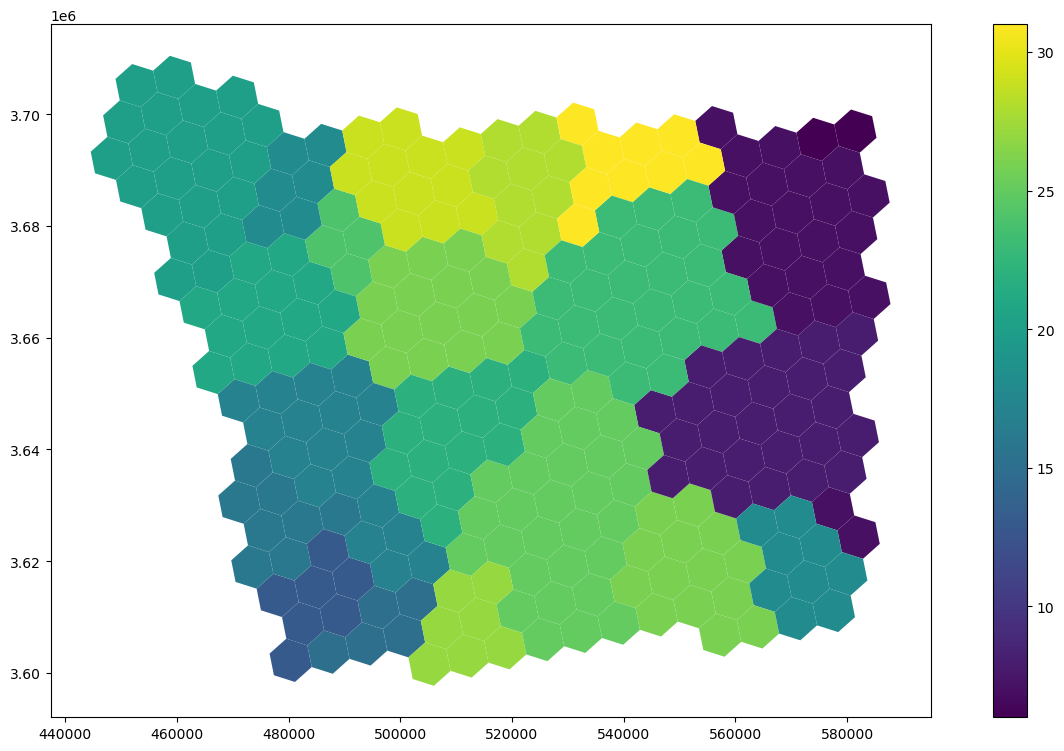

In [28]:
county_h3.plot(column='nn1_est', legend=True);

### Knn5

In [29]:
X = [[0], [1], [2], [3]]
y = [0, 0, 1, 1]
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X, y)
print(neigh.predict([[1.5]]))



[0.5]


In [30]:
# Set number of neighbors to use
neighbors = 5

# Initialize KNN regressor
knn_regressor = KNeighborsRegressor(n_neighbors = neighbors, weights = "uniform") # no distance decay distance

# Fit to observed locations
knn_regressor.fit(precip_utm.get_coordinates(), precip_utm.inches)

KNeighborsRegressor()

In [31]:
knn_regressor.predict(hcents.get_coordinates())


array([23.6, 20.4, 20. ,  9.2, 23.6, 22.4, 15. , 19.4, 15. , 20.4, 21.8,
       22.2, 21.4, 16.8, 23.6, 16.8, 16.8, 13.2, 15. , 16.8, 20.6, 18.6,
       20.6, 22. , 21.8, 23.6, 22. , 24.8, 20. , 15. , 17.4, 23.6, 20. ,
       15.6, 17.6, 27.4, 21.2, 19.4, 17.6, 25. , 19. , 22.6, 27.4, 20.6,
       17.6, 25. , 20.4, 22.4, 27.6, 21.2,  9.2, 17. , 23.6, 19.4, 12.6,
       24.2, 18.6, 16.8, 23.2, 21.8, 17. , 27.4, 25. , 22.6, 23.2, 17. ,
       15. , 23. , 23.6, 17.6, 20.4, 22. , 25. , 15.6, 21.6, 24.2, 23.6,
       21.4, 20.6, 17. , 18.8, 20.6, 20. , 15. , 16.8, 23.6, 16.8, 15. ,
       25.6, 22. , 24.2, 19.2, 19. , 25.4, 17.6, 19. , 15.6, 16.8, 15. ,
       21.2, 20.6, 19. , 21.8, 15. , 16.8, 19. , 25.6, 27.4, 18.6, 21.8,
       25. , 23. , 17. , 20.6, 15.6, 24.4, 27.4, 20.4, 15.6, 13.2, 23.6,
       26. , 13.2, 20. , 19.2, 16.8, 20.4, 27.4, 22.4, 27.6, 17. , 16.8,
       22. , 16.8, 26. , 22.4, 27.4, 20.6, 26.6, 16.8, 19. , 19. , 10.2,
       23.6, 22.6, 26.6, 20.6, 20.6, 21.8, 20.6, 23

In [32]:
county_h3['nn5_est'] = knn_regressor.predict(hcents.get_coordinates())


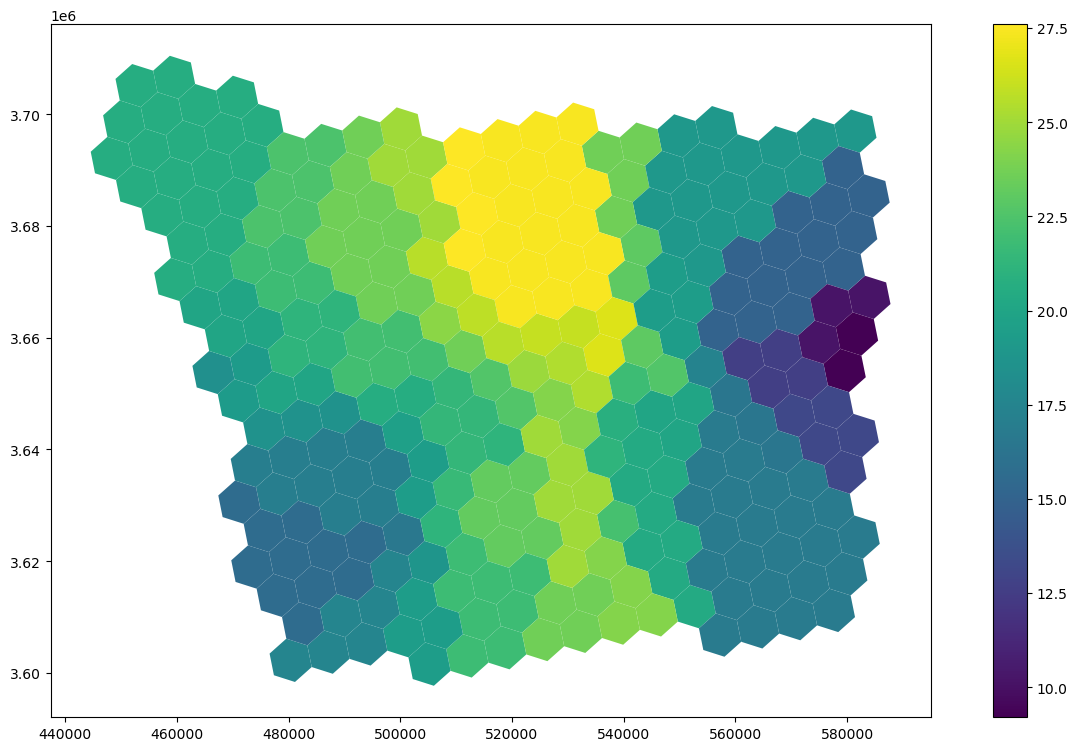

In [33]:
county_h3.plot(column='nn5_est', legend=True);

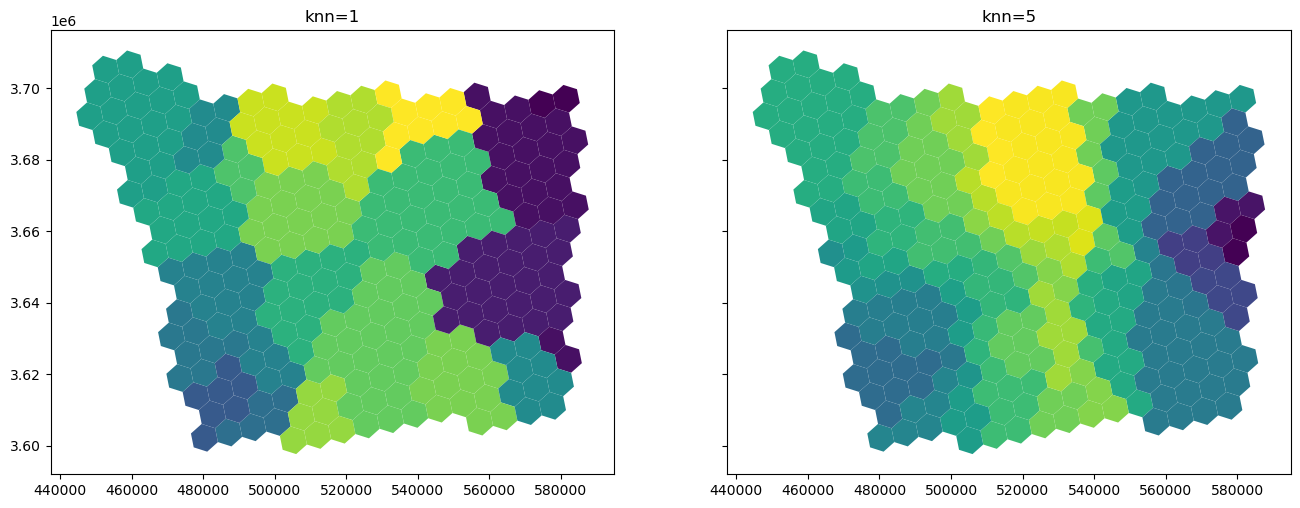

In [34]:
import matplotlib.pyplot as plt
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
county_h3.plot(column='nn1_est',ax=ax1)
county_h3.plot(column='nn5_est',ax=ax2)
ax1.set_title("knn=1")
ax2.set_title("knn=5");



In [35]:
# Set number of neighbors to use
neighbors = 5

# Initialize KNN regressor
knn_regressor = KNeighborsRegressor(n_neighbors = neighbors, weights = "distance") # inverse distance weighting
# Fit to observed locations
knn_regressor.fit(precip_utm.get_coordinates(), precip_utm.inches)

KNeighborsRegressor(weights='distance')

In [36]:
county_h3['nn5id_est'] = knn_regressor.predict(hcents.get_coordinates())


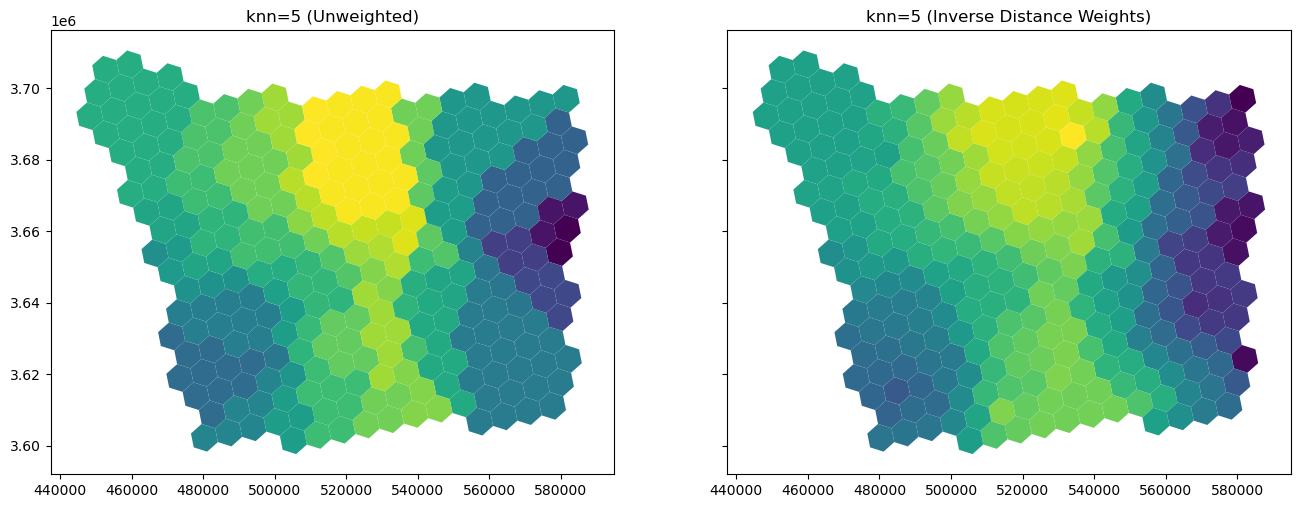

In [37]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
county_h3.plot(column='nn5_est',ax=ax1)
county_h3.plot(column='nn5id_est',ax=ax2)
ax1.set_title("knn=5 (Unweighted)")
ax2.set_title("knn=5 (Inverse Distance Weights)");
